New York State's Office of Addiction Services and Supports ([OASAS](https://oasas.ny.gov/)) oversees one of the nation’s largest Substance Use Disorder systems of care with approximately 1,700 prevention, treatment, and recovery programs serving over 680,000 individuals per year. By analysing data from these programs, we can see if the program has been effective over the past decade. We can also use this data to predict what the future may hold for OASAS to adjust strategies for treatment and prevention.


This project explores Admissions data from [OASAS](https://data.ny.gov/Human-Services/Chemical-Dependence-Treatment-Program-Admissions-B/ngbt-9rwf) from 2007 to 2018 about chemical dependence treatment programs in the state of New York. Using Facebook's Prophet, I forecast future admissions for these programs. To see some interesting visualizations, check out my [Tableau](https://public.tableau.com/profile/rachel.khoo#!/vizhome/ChemicalDependenceTreatmentAdmissions/11YearComparison-Substances) public profile.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import prophet as Prophet

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
df = pd.read_csv('Chemical_Dependence_Treatment_Program_Admissions__Beginning_2007.csv')

In [3]:
df.head()

,Year,County of Program Location,Program Category,Service Type,Age Group,Primary Substance Group,Admissions
0,2007,Albany,Crisis,Medical Managed Detoxification,Under 18,Heroin,4
1,2007,Albany,Crisis,Medical Managed Detoxification,18 thru 24,Alcohol,35
2,2007,Albany,Crisis,Medical Managed Detoxification,18 thru 24,Heroin,132
3,2007,Albany,Crisis,Medical Managed Detoxification,18 thru 24,Other Opioids,6
4,2007,Albany,Crisis,Medical Managed Detoxification,18 thru 24,All Others,2


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86374 entries, 0 to 86373
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Year                        86374 non-null  int64 
 1   County of Program Location  86374 non-null  object
 2   Program Category            86374 non-null  object
 3   Service Type                86374 non-null  object
 4   Age Group                   86374 non-null  object
 5   Primary Substance Group     86374 non-null  object
 6   Admissions                  86374 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 4.6+ MB


In [5]:
df['Year'].value_counts()

2019    6957
2018    6950
2017    6820
2012    6700
2010    6655
2011    6623
2013    6619
2007    6550
2009    6540
2008    6519
2014    6507
2015    6506
2016    6428
Name: Year, dtype: int64

In [6]:
df['Program Category'].value_counts()

Outpatient                  30574
Residential                 24081
Crisis                      16281
Inpatient                   11886
Opioid Treatment Program     3091
Specialized                   461
Name: Program Category, dtype: int64

In [7]:
df['Service Type'].value_counts()

Outpatient Clinic                    24028
Inpatient Rehabilitation             11876
Community Residential                10083
Outpatient Rehabilitation             6418
Intensive Residential                 5745
Medical Managed Detoxification        5631
Medically Monitored Withdrawal        4989
Med Sup Withdrawal - Inpatient        4809
Supportive Living                     4687
Opioid Outpatient Treatment           2523
Residential Rehab for Youth           1194
Med Sup Withdrawal-Outpatient          852
Stabilization Rehab Reintegration      796
Stabilization and Rehab                583
Residential Stabilization              339
Specialized Services Outpt Rehab       254
Residential Reintegration              250
Residential Rehabilitation             238
OTP Intensive Residential              206
Limited Outpatient/KEEP                193
MAOT-A-Residential                     169
Specialized Outpatient - TBI           136
Rehab and Reintegration                132
Outpat Chem

In [8]:
df['County of Program Location'].value_counts()

New York    4514
Suffolk     3370
Queens      3242
Dutchess    3100
Erie        3087
            ... 
Tioga        311
Essex        310
Schuyler     299
Yates        289
Lewis        137
Name: County of Program Location, Length: 61, dtype: int64

Since the distribution of admissions is likely to follow the population density of the counties, population data for each county would be helpful to compare admission numbers to total number of people in that county. Additionally, Hamilton county is missing from this dataset.

In [9]:
population_df = pd.read_csv('NY County Population - Sheet1.csv')
population_df['Year'] = population_df['Year'].astype(int)
population_df['Population'] = population_df['Population'].astype(int)
population_df

,County,Population,Year
0,Bronx,1373659,2007
1,Kings,2528050,2007
2,New York,1620867,2007
3,Queens,2270338,2007
4,Richmond,481613,2007
...,...,...,...
739,Washington,61197,2018
740,Wayne,90064,2018
741,Westchester,967612,2018
742,Wyoming,40085,2018


In [10]:
df=pd.merge(df, population_df,how='outer', left_on =['County of Program Location', 'Year'], right_on = ['County', 'Year'])

In [11]:
df['Percent'] = (df['Admissions'] / df['Population']) * 100

In [12]:
df.dropna(inplace=True)
df.drop(columns=['County'], inplace=True)
df['Admissions'] = df['Admissions'].astype(int)
df['Population'] = df['Population'].astype(int)


In [13]:
grouped = df.groupby(['Year', 'County of Program Location', 'Primary Substance Group', 'Age Group','Population'], as_index=False).sum()

In [14]:
grouped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22484 entries, 0 to 22483
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Year                        22484 non-null  int64  
 1   County of Program Location  22484 non-null  object 
 2   Primary Substance Group     22484 non-null  object 
 3   Age Group                   22484 non-null  object 
 4   Population                  22484 non-null  int64  
 5   Admissions                  22484 non-null  int32  
 6   Percent                     22484 non-null  float64
dtypes: float64(1), int32(1), int64(2), object(3)
memory usage: 1.3+ MB


In [15]:
#created a csv to use in Tableau
grouped.to_csv(r'C:\Users\rhais\Documents\GitHub\Personal\grouped.csv', index=False)

In [16]:
df.groupby(['County of Program Location'], as_index=False).sum().sort_values('Percent', ascending=False).head(5)[['County of Program Location', 'Percent']]

,County of Program Location,Percent
38,Putnam,76.559360
44,Schenectady,59.552855
29,New York,32.506302
50,Sullivan,30.354077
0,Albany,29.656560


Putnam, Schedectady, New York, Sullivan, and Albany county have the highest overall admissions proportional to county population. New York County is the wealthiest county, followed by Putnam (4th overall), Albany (10th), Schenectady (17th), and Sullivan (36th) based on [per capita income]('https://en.wikipedia.org/wiki/List_of_New_York_locations_by_per_capita_income').

In [17]:
df['Age Group'].value_counts()

25 thru 34      16816
18 thru 24      15965
35 thru 44      15584
45 thru 54      14258
55 and Older    10928
Under 18         4569
Name: Age Group, dtype: int64

In [18]:
df['Primary Substance Group'].value_counts()

Alcohol                   15762
Heroin                    15127
Other Opioids             13331
Cocaine incl Crack        12800
Marijuana incl Hashish    11441
All Others                 9658
None                          1
Name: Primary Substance Group, dtype: int64

Alcohol and heroin seem to be the most abused substances over the 11 years covered in this dataset. It will be interesting to see how dependence has changed. I'm going to drop the one record with "None" as the substance.

In [19]:
df = df[~(df['Primary Substance Group'] == 'None')]

# Past Data (2007 - 2019)

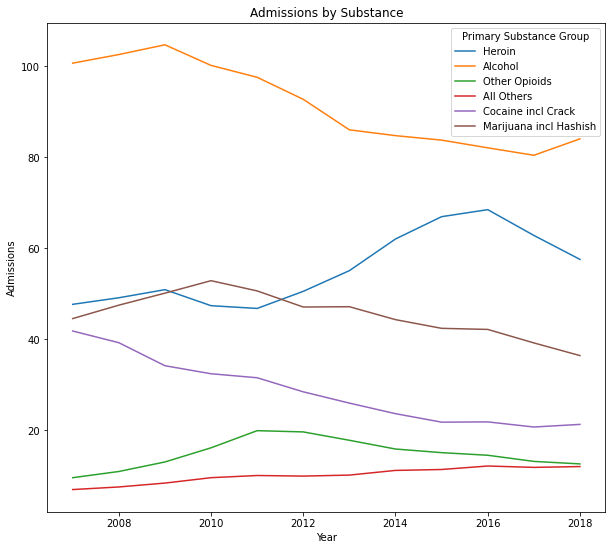

In [41]:
plt.figure(figsize=(10,9))
sns.lineplot(data=df,x='Year', y = 'Admissions', hue='Primary Substance Group', ci=None)
plt.title('Admissions by Substance')
plt.show()

There has been a decrease in admissions due to alcohol, though there was a slight uptick from 2017 to 2018. Admissions due to marijuana have decreased, possibly due to the drug's increasing legalization. Heroin experienced the greatest increase of all other substances, particularly starting in 2012. In 2011, a [new commissioner](https://oasas.ny.gov/commissioner-biography) of the OASAS was appointed, and some changes that occured in subsequent years could be attributed to programs she instituted. The Statewide Task Force to Combat Heroin and the Prescription Opioid Crisis was established 2016, and the number of admissions due to heroin and other opioids did decrease, suggesting this program is effective.  

In [21]:
sub_df= df.groupby(['Age Group','Year', 'Primary Substance Group'], as_index=False).sum()

dropdown = ['Under 18','18 thru 24','25 thru 34','35 thru 44','45 thru 54','55 and Older']
@interact(Field = dropdown)
def viz(Field):
    cond = sub_df[sub_df['Age Group'] == Field]
    fig = px.bar(data_frame = cond, x= 'Year',y='Admissions', color='Primary Substance Group')
    fig.show()


interactive(children=(Dropdown(description='Field', options=('Under 18', '18 thru 24', '25 thru 34', '35 thru …

In [22]:
age_df= df.groupby(['Year','Age Group'], as_index=False).sum()

dropdown = ['Under 18','18 thru 24','25 thru 34','35 thru 44','45 thru 54','55 and Older']
@interact(Field = dropdown)
def viz(Field):
  fig = px.line(data_frame=age_df[age_df['Age Group'] == Field], x='Year', y='Admissions', title=f'{Field} Total Admissions')
  fig.show()

interactive(children=(Dropdown(description='Field', options=('Under 18', '18 thru 24', '25 thru 34', '35 thru …

Admissions for children under 18 have more than halved in the past decade.

# Forecasting

I will be using Facebooks's Prophet to predict future admissions. Prophet is easy to use and not much has to be done to the data prior to modeling.

In [23]:
prophet_df = df.groupby('Year', as_index=False).sum()[['Year', 'Admissions']]
prophet_df.columns = ['ds', 'y']

In [24]:
prophet_df['ds']=pd.to_datetime(prophet_df['ds'], format= '%Y')

In [25]:
m = Prophet.Prophet(daily_seasonality=False, weekly_seasonality=False, n_changepoints=9)
m.fit(prophet_df)

INFO:prophet:n_changepoints greater than number of observations. Using 8.


In [26]:
future = m.make_future_dataframe(periods=10, freq='Y')
future.tail()

,ds
17,2023-12-31
18,2024-12-31
19,2025-12-31
20,2026-12-31
21,2027-12-31


In [27]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
17,2023-12-31,236074.903253,229937.906891,242654.250271
18,2024-12-31,239093.848335,232520.463672,245320.602927
19,2025-12-31,233360.140624,227121.712440,239296.271926
20,2026-12-31,227262.075716,221200.809895,232974.358379
21,2027-12-31,220804.392826,214036.897958,226852.053300


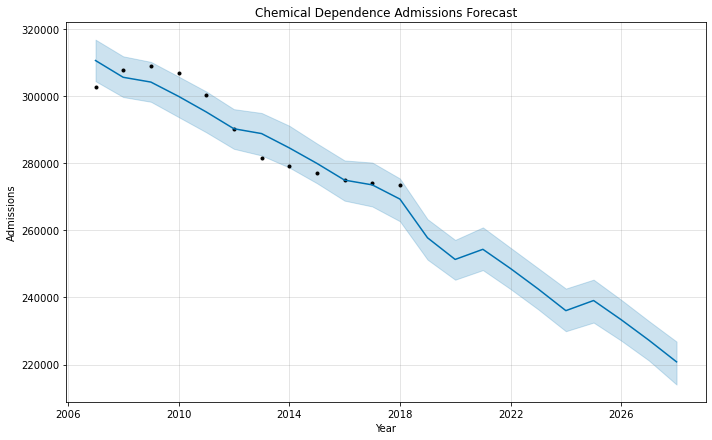

In [28]:
m.plot(forecast)
plt.title('Chemical Dependence Admissions Forecast')
plt.xlabel('Year')
plt.ylabel('Admissions')
plt.show()

In [42]:
age_dropdown = ['Under 18','18 thru 24','25 thru 34','35 thru 44','45 thru 54','55 and Older']
@interact(Age = age_dropdown)
def viz(Age):
    specific_df = df[df['Age Group'] == Age]
    prophet_df = specific_df.groupby('Year', as_index=False).sum()[['Year','Admissions']]
    prophet_df.columns = ['ds', 'y']
    prophet_df['ds']=pd.to_datetime(prophet_df['ds'], format= '%Y')
    m = Prophet.Prophet(daily_seasonality=False, weekly_seasonality=False, n_changepoints = 4)
    m.fit(prophet_df)
    future = m.make_future_dataframe(periods=4, freq='Y')
    forecast = m.predict(future)
    m.plot(forecast)
    plt.title('Chemical Dependence Admissions Forecast')
    plt.xlabel('Year')
    plt.ylabel('Admissions')
    plt.show()

interactive(children=(Dropdown(description='Age', options=('Under 18', '18 thru 24', '25 thru 34', '35 thru 44…

In [29]:
age_dropdown = ['Under 18','18 thru 24','25 thru 34','35 thru 44','45 thru 54','55 and Older']
substance_dropdown = list(df['Primary Substance Group'].value_counts().keys())
@interact(Age = age_dropdown, Substance = substance_dropdown)
def viz(Age, Substance):
    specific_df = df[(df['Age Group'] == Age) & (df['Primary Substance Group'] == Substance)]
    prophet_df = specific_df.groupby('Year', as_index=False).sum()[['Year','Admissions']]
    prophet_df.columns = ['ds', 'y']
    prophet_df['ds']=pd.to_datetime(prophet_df['ds'], format= '%Y')
    m = Prophet.Prophet(daily_seasonality=False, weekly_seasonality=False, n_changepoints = 4)
    m.fit(prophet_df)
    future = m.make_future_dataframe(periods=4, freq='Y')
    forecast = m.predict(future)
    m.plot(forecast)
    plt.title('Chemical Dependence Admissions Forecast')
    plt.xlabel('Year')
    plt.ylabel('Admissions')
    plt.show()


interactive(children=(Dropdown(description='Age', options=('Under 18', '18 thru 24', '25 thru 34', '35 thru 44…

Over the past decade, overall admissions for chemical dependence are down.  There was a peak in 2009, possibly a delayed effect of the 2008 financial crisis. It is important to note, however, that just because admissions for treatment of chemical dependence have decrease, it does not necessarily indicate that the prevalence of chemical dependence has decreased, just that not as many people are seeking treatment.

For children under 18, marijuana is by far the substance for which patients are seeking dependence treatment the most, followed by alcohol. Admissions for people 55 and older have increased across all substance groups, with alcohol being the higest, followed by heroin. Admissions for 25-34 year-olds dependent on heroin saw a huge increase from 2011 to 2016. The overall national opiod dispensing rate peaked in [2012]('https://www.cdc.gov/drugoverdose/maps/rxrate-maps.html')</sup>, and perhaps addicts turned to illegal substitutes after the dispensing rates declined in subsequent years.



Overall admissions are expected to decline over the next decade, with periodic spikes that may follow changes in the economy. However, admissions for people between the ages of 25 to 34 are expected to increase, primarily due to heroin and other opiods. People under age 25 are expected to be admitted much less frequently, possibly because of the effectiveness of OASAS's prevention programs. People over 55 are expected to be admitted more for every substance. These patients may be life-long users, so changing this trend may prove difficult. 

It is encouraging to see that overall, admissions for chemical dependence are on the decline. OASAS may want to target older patients and young opioid addicts to address the predicted increase in admissions. 